# ML Pipeline using Sagemaker Clarify

In [1]:
!./setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [2]:
# Load libraries
import sagemaker
import boto3
from sagemaker import Session, get_execution_role, local, Model, utils, fw_utils, s3
import pandas as pd
import numpy as np
import urllib
import os
import time
from time import strftime

sess = boto3.Session(region_name='ap-southeast-1')
session = sagemaker.Session(boto_session=sess)
region = session.boto_region_name
role = get_execution_role()
region = session.boto_region_name
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
    )
account = client.get_caller_identity()['Account']
bucket = 'ml-innovate-2021'
prefix = 'clarify-test'
create_date = strftime("%Y-%m-%d-%H-%M-%S")
print(create_date)
new_prefix = os.path.join(prefix, f'Exp-{create_date}')

2021-01-24-12-01-44


### Download Data

In [3]:
adult_columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
                 "Occupation", "Relationship", "Ethnic group", "Gender", "Capital Gain", "Capital Loss",
                 "Hours per week", "Country", "Target"]

urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data','adult.data')
print('adult.data saved!')

urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test','adult.test')
print('adult.test saved!')

adult.data saved!
adult.test saved!


### Prepare Data

In [4]:
training_data = pd.read_csv("adult.data",
                             names=adult_columns,
                             sep=r'\s*,\s*',
                             engine='python',
                             na_values="?").dropna()

testing_data = pd.read_csv("adult.test",
                            names=adult_columns,
                            sep=r'\s*,\s*',
                            engine='python',
                            na_values="?",
                            skiprows=1).dropna()

In [5]:
training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Gender,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


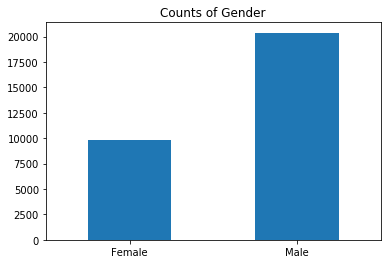

In [8]:
# Visualize distribution of protected attribute
training_data['Gender'].value_counts().sort_values().plot(kind='bar', title='Counts of Gender', rot=0)

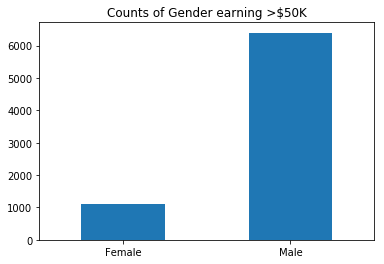

In [7]:
# Visualize distribution of outcome corresponding to protected attribute
training_data['Gender'].where(training_data['Target']=='>50K').value_counts().sort_values().plot(kind='bar', title='Counts of Gender earning >$50K', rot=0)

In [9]:
# Encode Female to '0' and Male to '1'
from sklearn import preprocessing
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
    return result, encoders

training_data = pd.concat([training_data['Target'], training_data.drop(['Target'], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv('train_data.csv', index=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(['Target'], axis = 1)
test_target = testing_data['Target']
test_features.to_csv('test_features.csv', index=False)

In [41]:
from collections import Counter
print(Counter(training_data['Target']))

Counter({0: 22654, 1: 7508})


In [10]:
# Upload data to S3
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload('train_data.csv', 's3://{}/{}/train'.format(bucket, new_prefix))
train_input = TrainingInput(train_uri, content_type='text/csv')
test_uri = S3Uploader.upload('test_features.csv', 's3://{}/{}/test'.format(bucket, new_prefix))
print('train_uri:', train_uri)
print('train_input:', train_input)
output_path = f's3://{bucket}/{prefix}/{create_date}/output'

train_uri: s3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/train/train_data.csv
train_input: <sagemaker.inputs.TrainingInput object at 0x7f85ccd720b8>


### Balance Training Dataset

In [42]:
from sagemaker.processing import ScriptProcessor

processing_repository_uri = '963992372437.dkr.ecr.ap-southeast-1.amazonaws.com/ml-innovate-pp'
script_processor = ScriptProcessor(command=['python3'],
                image_uri=processing_repository_uri,
                role=role,
                instance_count=1,
                instance_type='ml.m5.xlarge')

In [45]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

source = os.path.join('s3://', bucket, new_prefix, 'train/train_data.csv')
destination = os.path.join('s3://', bucket, new_prefix)

script_processor.run(code='container/preprocessing.py',
                      inputs=[ProcessingInput(
                        source=source,
                        destination='/opt/ml/processing/input/data')],
                      outputs=[ProcessingOutput(destination=os.path.join(destination, 'train_balanced'),
                                                source='/opt/ml/processing/train')])
script_processor_job_description = script_processor.jobs[-1].describe()


Job Name:  ml-innovate-pp-2021-01-24-14-00-10-971
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/train/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/ml-innovate-pp-2021-01-24-14-00-10-971/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/train_balanced', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}]
........................
Entered Processi

In [46]:
new_train_uri = os.path.join(destination, 'train_balanced', 'train_balanced.csv')
print(new_train_uri)

s3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/train_balanced/train_balanced.csv


In [47]:
from sagemaker.s3 import S3Downloader

S3Downloader.download(new_train_uri, local_path='.')

In [48]:
training_balanced = pd.read_csv("train_balanced.csv")

In [49]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Gender,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [50]:
training_balanced.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Gender,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [51]:
from collections import Counter
print(Counter(training_data['Target']))
print(Counter(training_balanced['Target']))

Counter({0: 22654, 1: 7508})
Counter({0: 22654, 1: 22654})


### Pre-Training Fairness Assessment

In [52]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=session)

In [53]:
bias_report_output_path = 's3://{}/{}/clarify-bias-{}'.format(bucket, prefix, create_date)
bias_data_config = clarify.DataConfig(s3_data_input_path=new_train_uri,
                                      s3_output_path=bias_report_output_path,
                                      label='Target',
                                      headers=training_data.columns.to_list(),
                                      dataset_type='text/csv')

bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='Gender',
                                facet_values_or_threshold=[0],
                                group_name='Education')

In [54]:
some_random = strftime("%Y-%m-%d-%H-%M-%S")
clarify_processor.run_pre_training_bias(data_config=bias_data_config,
                                        data_bias_config=bias_config, 
                                        methods='all', 
                                        wait=True, 
                                        logs=True, 
                                        job_name=f'pretraining-bias1-{some_random}')


Job Name:  pretraining-bias1-2021-01-24-14-33-30
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/train_balanced/train_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/pretraining-bias1-2021-01-24-14-33-30/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/clarify-bias-2021-01-24-12-01-44', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


### Training: HPO

In [55]:
from sagemaker.estimator import Estimator

new_prefix = os.path.join(prefix, f'Exp-{create_date}')

hyperparameters = {
    "max_depth": "10",
    "eta": "1",
    "gamma": "1",
    "min_child_weight": "6",
    "objective": 'binary:logistic',
    "num_class": "2",
    "num_round": "40",
    "s3_bucket": os.path.join(bucket, new_prefix, 'debug'),
    "protected": "Gender",
    "thresh": "0.8"
}

output_path = 's3://{0}/{1}/output/'.format(bucket, new_prefix)

estimator = Estimator(
    image_uri='963992372437.dkr.ecr.ap-southeast-1.amazonaws.com/clarify-xgb:latest',
    role=role,
    sagemaker_session=session,
    instance_count=1,
    instance_type='ml.m5.4xlarge',
    output_path=output_path,
    hyperparameters=hyperparameters
)

In [56]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter
from time import gmtime, strftime

hyperparameter_ranges = {
    'eta': ContinuousParameter(1,2),
    #'alpha': ContinuousParameter(0,1000),
    'gamma': IntegerParameter(1,5),
    'min_child_weight': IntegerParameter(1,10),
    'max_depth': IntegerParameter(1,10),
    "num_round": IntegerParameter(4,30)
}

metric_definitions = [{'Name': 'validation-f1',
                       'Regex': 'validation-f1: ([0-9\\\\.]+)'}]

# Configure HyperparameterTuner
my_tuner = HyperparameterTuner(estimator=estimator,
                               objective_metric_name='validation-f1',
                               objective_type='Maximize',
                               hyperparameter_ranges=hyperparameter_ranges,
                               metric_definitions=metric_definitions,
                               strategy='Random',
                               max_jobs=100,
                               max_parallel_jobs=10)

# Start hyperparameter tuning job
tuning_job_name = "tuning-{}".format(create_date)
my_tuner.fit({'train': train_input}, wait=False, include_cls_metadata=False, job_name=tuning_job_name)

In [58]:
my_tuner.describe()['HyperParameterTuningJobStatus']

'Completed'

In [59]:
tuning_job_name

'tuning-2021-01-24-12-01-44'

### Finding the Best Model: Fairness / Performance Tradeoff

In [60]:
from sagemaker.s3 import S3Downloader
import tarfile
import pickle as pkl
import xgboost

smclient=boto3.client('sagemaker',region_name='ap-southeast-1')
trjobs = smclient.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    MaxResults=100,
    SortBy='FinalObjectiveMetricValue',
    SortOrder='Descending')

job_arr = []
train_metric = []
val_metric = []
dsp_train = []
dsp_val = []
sr_train = []
sr_val = []
dpd_train = []
dpd_val = []
dpr_train = []
dpr_val = []
eod_train = []
eod_val = []
exp_destination = os.path.join('s3://', bucket, new_prefix)
for trjob in trjobs['TrainingJobSummaries']:
    #print(trjob)
    model_path = os.path.join(exp_destination,'output',trjob["TrainingJobName"],'output','model.tar.gz')
    job_arr.append(trjob["TrainingJobName"])
    #print(model_path)
    S3Downloader.download(model_path, local_path='.')
    with tarfile.open('model.tar.gz') as tar:
        tar.extractall(path='hpo_model/')
    with open('hpo_model/model.bin','rb') as f:
        iteration = pkl.load(f)
        model = pkl.load(f)
    with open('hpo_model/best_metrics.pkl','rb') as f:
        train_metric.append(pkl.load(f))
        val_metric.append(pkl.load(f))
        dsp_train.append(pkl.load(f))
        dsp_val.append(pkl.load(f))
        sr_train.append(pkl.load(f))
        sr_val.append(pkl.load(f))
        dpd_train.append(pkl.load(f))
        dpd_val.append(pkl.load(f))
        dpr_train.append(pkl.load(f))
        dpr_val.append(pkl.load(f))
        eod_train.append(pkl.load(f))
        eod_val.append(pkl.load(f))

metric_arr = pd.DataFrame({'jobname': job_arr,'train_f1':train_metric,'val_f1':val_metric,'train_dsp':dsp_train,
                           'val_dsp':dsp_val,'train_sr':sr_train,'val_sr':sr_val,'train_dpd':dpd_train,
                           'val_dpd':dpd_val,'train_dpr':dpr_train,'val_dpr':dpr_val,'train_eod':eod_train,
                           'val_eod':eod_val})

In [61]:
metric_arr

,jobname,train_f1,val_f1,train_dsp,val_dsp,train_sr,val_sr,train_dpd,val_dpd,train_dpr,val_dpr,train_eod,val_eod
0,tuning-2021-01-24-12-01-44-083-23b891b9,0.729382,0.728111,0.089491,0.102073,0.101202,0.107427,0.089491,0.102073,0.312859,0.273375,0.055403,0.095722
1,tuning-2021-01-24-12-01-44-088-67d3d969,0.715309,0.724246,0.096286,0.099810,0.110941,0.112898,0.096286,0.099810,0.322468,0.313999,0.070490,0.039766
2,tuning-2021-01-24-12-01-44-009-34327abb,0.736534,0.723870,0.095831,0.098409,0.106921,0.109416,0.095831,0.098409,0.305299,0.304807,0.074814,0.034378
3,tuning-2021-01-24-12-01-44-086-e0b71f0a,0.716359,0.723252,0.077818,0.082990,0.100953,0.100298,0.077818,0.082990,0.382783,0.350072,0.008637,0.038596
4,tuning-2021-01-24-12-01-44-056-f06d6e48,0.706452,0.719944,0.081870,0.095769,0.097642,0.102934,0.081870,0.095769,0.340472,0.286740,0.028820,0.084641
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,tuning-2021-01-24-12-01-44-062-122a3012,0.617682,0.631463,0.062524,0.066753,0.197853,0.199072,0.062524,0.066753,0.713564,0.696676,0.193094,0.180236
95,tuning-2021-01-24-12-01-44-047-f8bd9977,0.616061,0.629050,0.060717,0.050119,0.192548,0.204210,0.060717,0.050119,0.713928,0.772654,0.200746,0.180497
96,tuning-2021-01-24-12-01-44-005-f4892746,0.612734,0.624161,0.061305,0.051789,0.193659,0.195789,0.061305,0.051789,0.712867,0.756518,0.186590,0.154721
97,tuning-2021-01-24-12-01-44-063-321cbde1,0.613015,0.623161,0.000235,0.000943,0.057563,0.063992,0.000235,0.000943,0.995930,0.985406,0.220041,0.244966


In [62]:
metric_arr[['val_f1','val_dsp']].describe()

,val_f1,val_dsp
count,99.000000,99.000000
mean,0.690887,0.093693
std,0.028640,0.029958
min,0.616878,0.000943
25%,0.674737,0.084691
50%,0.701097,0.096522
75%,0.711496,0.105500
max,0.728111,0.166645


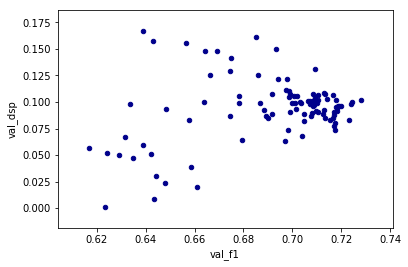

In [63]:
metric_arr.plot.scatter(x='val_f1',y='val_dsp',c='DarkBlue')

In [64]:
epsilon=0.05
bestjob = list(metric_arr[(metric_arr['val_dsp'] < 0.05) & (metric_arr['val_f1'] > 0.66)]['jobname'])[0]
print('bestjob: ', bestjob)
model_path = os.path.join(exp_destination,'output',bestjob,'output','model.tar.gz')
print(model_path)

bestjob:  tuning-2021-01-24-12-01-44-068-b5731e14
s3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/output/tuning-2021-01-24-12-01-44-068-b5731e14/output/model.tar.gz


### Deploy Model

In [65]:
from sagemaker.xgboost.model import XGBoostModel

xgboost_model = XGBoostModel(
    model_data=model_path,
    role=role,
    entry_point="container/inference.py",
    framework_version="1.2-1"
)

In [66]:
predictor = xgboost_model.deploy(
    endpoint_name="testing-clarify1-endpoint-{}".format(create_date),
    instance_type='ml.m4.xlarge',
    initial_instance_count=1
)
predictor.serializer = sagemaker.serializers.CSVSerializer(content_type='text/csv')

---------------!

In [67]:
print(xgboost_model.name)

sagemaker-xgboost-2021-01-24-15-40-20-487


In [68]:
X=test_features.to_numpy()
print(predictor.predict(X[0]))
res = []
for i in range(0,len(X),10):
    t=predictor.predict(X[i:i+10])
    res.extend([x[0] for x in t])

[['1.2181865e-18', '-1.0430605', '0.0', '0.0', '0.0', '-0.4071461', '0.0', '0.0', '-32.718716', '0.0', '0.0', '-0.44227165', '-0.17224817', '0.0', '0.0', '-6.465731']]


In [82]:
pred = [float(r) for r in res]
tr = list(testing_data['Target'].to_numpy())

In [83]:
from sklearn.metrics import f1_score
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference
from fairlearn.metrics import selection_rate

def fair_metrics(tr,pred,column,thresh):
    pred = [1 if p > thresh else 0 for p in pred]
    na0=0
    na1=0
    nd0=0
    nd1=0
    for p,c in zip(pred,column):
        if (p==1 and c==0):
            nd1 += 1
        if (p==1 and c==1):
            na1 += 1
        if (p==0 and c==0):
            nd0 += 1
        if (p==0 and c==1):
            na0 += 1
    Pa1, Pd1, Pa0, Pd0 = na1/(na1+na0), nd1/(nd1+nd0), na0/(na1+na0), nd0/(nd1+nd0)
    dsp_metric = np.abs(Pd1-Pa1)
    sr_metric = selection_rate(tr, pred, pos_label=1)
    dpd_metric = demographic_parity_difference(tr, pred, sensitive_features=column)
    dpr_metric = demographic_parity_ratio(tr, pred, sensitive_features=column)
    eod_metric = equalized_odds_difference(tr, pred, sensitive_features=column)
    f1_metric = f1_score(tr, pred, average='macro')
    
    return f1_metric, dsp_metric, sr_metric, dpd_metric, dpr_metric, eod_metric

protected_col = list(testing_data['Gender'].to_numpy())
thresh = 0.8
f1_metric, dsp_metric, sr_metric, dpd_metric, dpr_metric, eod_metric = fair_metrics(tr,pred,protected_col,thresh)
print('f1_metric: ',f1_metric)
print('dsp_metric: ',dsp_metric)
print('sr_metric: ',sr_metric)
print('dpd_metric: ',dpd_metric)
print('dpr_metric: ',dpr_metric)
print('eod_metric: ',eod_metric)

f1_metric:  0.6682107473914647
dsp_metric:  0.0038515041990815485
sr_metric:  0.08645418326693227
dpd_metric:  0.0038515041990815485
dpr_metric:  0.9560885245976624
eod_metric:  0.2554084166404383


### Visual Assessment of Test Data

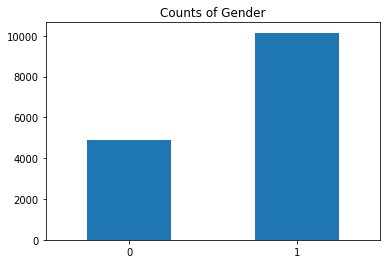

In [69]:
# Visualize distribution of protected attribute
testing_data['Gender'].value_counts().sort_values().plot(kind='bar', title='Counts of Gender', rot=0)

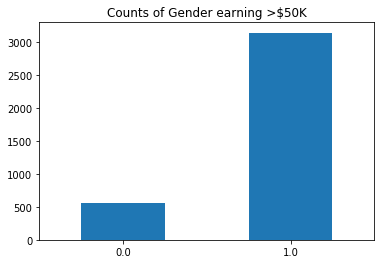

In [70]:
# Visualize distribution of outcome corresponding to protected attribute
testing_data['Gender'].where(testing_data['Target']==1).value_counts().sort_values().plot(kind='bar', title='Counts of Gender earning >$50K', rot=0)

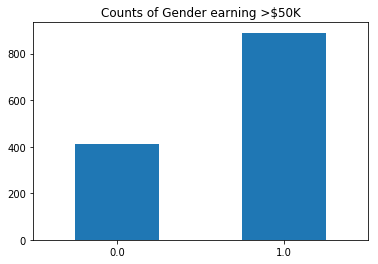

In [71]:
res_val=[1 if float(r) >= 0.8 else 0 for r in res]
testing_result = testing_data.copy()
testing_result['Pred_Target'] = np.array(res_val)
testing_result['Gender'].where(testing_result['Pred_Target']==1).value_counts().sort_values().plot(kind='bar', title='Counts of Gender earning >$50K', rot=0)

### Post-Training Fairness Assessment - Training Data

In [72]:
model_name = xgboost_model.name
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [73]:
clarify_processor.run_post_training_bias(data_config=bias_data_config,
                                         data_bias_config=bias_config,
                                         model_config=model_config,
                                         model_predicted_label_config=predictions_config,
                                         methods='all',
                                         wait=True,
                                         logs=True,
                                         job_name=f'posttraining-bias-{create_date}')


Job Name:  posttraining-bias-2021-01-24-12-01-44
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/train_balanced/train_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/posttraining-bias-2021-01-24-12-01-44/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/clarify-bias-2021-01-24-12-01-44', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


### Explaining Predictions - Training Data

In [76]:
shap_config = clarify.SHAPConfig(baseline=[test_features.iloc[0].values.tolist()],
                                 num_samples=15,
                                 agg_method='mean_abs')

explainability_output_path = 's3://{}/{}/clarify-explainability-{}'.format(bucket, new_prefix, create_date)
explainability_data_config = clarify.DataConfig(s3_data_input_path=new_train_uri,
                                s3_output_path=explainability_output_path,
                                label='Target',
                                headers=training_data.columns.to_list(),
                                dataset_type='text/csv')

In [77]:
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)


Job Name:  Clarify-Explainability-2021-01-24-16-24-32-945
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/train_balanced/train_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/Clarify-Explainability-2021-01-24-16-24-32-945/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/clarify-explainability-2021-01-24-12-01-44', 'LocalPath': '/opt/m

### Post-Training Fairness Assessment - Testing Data

In [78]:
testing_data.to_csv('testing_data.csv', index=False)
testing_uri = S3Uploader.upload('testing_data.csv', 's3://{}/{}'.format(bucket, new_prefix))

In [79]:
test_bias_report_output_path = 's3://{}/{}/clarify-bias-test-{}'.format(bucket, prefix, create_date)
test_bias_data_config = clarify.DataConfig(s3_data_input_path=testing_uri,
                                      s3_output_path=test_bias_report_output_path,
                                      label='Target',
                                      headers=testing_data.columns.to_list(),
                                      dataset_type='text/csv')

test_bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='Gender',
                                facet_values_or_threshold=[0],
                                group_name='Education')

In [80]:
clarify_processor.run_post_training_bias(data_config=test_bias_data_config,
                                         data_bias_config=test_bias_config,
                                         model_config=model_config,
                                         model_predicted_label_config=predictions_config,
                                         methods='all',
                                         wait=True,
                                         logs=True,
                                         job_name=f'posttesting--bias-{create_date}')


Job Name:  posttesting--bias-2021-01-24-12-01-44
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-12-01-44/testing_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/posttesting--bias-2021-01-24-12-01-44/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/clarify-bias-test-2021-01-24-12-01-44', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
............